In [1]:
import matplotlib.pyplot as plt
import glob 
import cv2
import os
import random
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
import tensorflow as tf


print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## Read Data

In [2]:
img_size = 48    
batch_size = 64
datagen_train = ImageDataGenerator(rescale=1.0/255.0)


train_generator = datagen_train.flow_from_directory("C:/Users/fatem/Downloads/images_face/train",
                                                  target_size = (img_size,img_size),
                                                  color_mode = "grayscale",
                                                  batch_size = batch_size,
                                                  class_mode = "categorical",
                                                  shuffle = True)

datagen_test = ImageDataGenerator(rescale=1.0/255.0)
test_generator = datagen_test.flow_from_directory("C:/Users/fatem/Downloads/images_face/test",
                                                  target_size = (img_size,img_size),
                                                  color_mode = "grayscale",
                                                  batch_size = batch_size,
                                                  class_mode = "categorical",
                                                  shuffle = True)




Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Found 28709 images belonging to 7 classes.


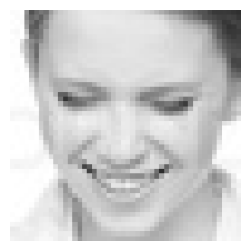

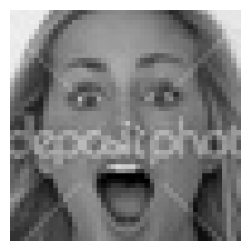

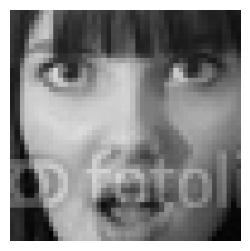

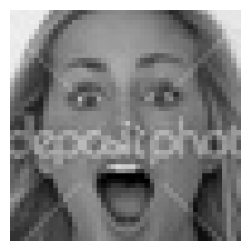

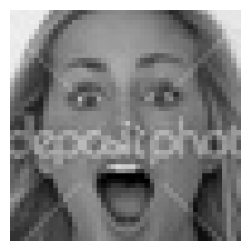

In [3]:
datagen_train = ImageDataGenerator(rescale=1./255) 
images, labels = next(datagen_train.flow_from_directory("C:/Users/fatem/Downloads/images_face/train", batch_size=9))

for i in range(5):
    image = random.choice(images)
    image = (image * 255).astype('uint8')  
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [4]:
import numpy as np

train_features = []
train_labels = []


idx = 500
for x_batch, y_batch in train_generator:
    train_features.append(x_batch)
    train_labels.append(y_batch)
    idx -= 1
    if idx < 1:
        break

train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)
train_features = train_features.reshape(train_features.shape[0], -1) 

In [5]:
import numpy as np

test_features = []
test_labels = []

idx = 500
for x_batch, y_batch in test_generator:
    test_features.append(x_batch)
    test_labels.append(y_batch)
    idx -= 1
    if idx < 1:
        break


test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)
test_features = test_features.reshape(test_features.shape[0], -1)  

In [6]:
print(test_features.shape)
print(test_labels.shape)

(31784, 2304)
(31784, 7)


In [7]:
print(train_features.shape)
print(train_labels.shape)

(31973, 2304)
(31973, 7)


In [8]:
test_labels[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [9]:
train_labels[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [10]:
test_features[0]

array([0.12941177, 0.20784315, 0.2509804 , ..., 0.07843138, 0.15686275,
       0.2509804 ], dtype=float32)

In [11]:
train_features[0]

array([0.4901961 , 0.5058824 , 0.5019608 , ..., 0.23137257, 0.31764707,
       0.3803922 ], dtype=float32)

# PCA

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=400)
train_features_reducted = pca.fit_transform(train_features)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=400)
test_features_reducted = pca.fit_transform(test_features)

In [14]:
train_features_reducted.shape

(31973, 400)

In [15]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
def calculate(y_train,y_test,y_pred_train,y_pred_test):
    acc_train=accuracy_score(y_true=y_train,y_pred=y_pred_train)
    acc_test=accuracy_score(y_true=y_test,y_pred=y_pred_test)
    
    p=precision_score(y_true=y_test,y_pred=y_pred_test,average="weighted")
    r=recall_score(y_true=y_test,y_pred=y_pred_test,average="weighted")

    print(f"acc train: {acc_train} - acc test: {acc_test} - precision: {p} - recall: {r}")
    return acc_train,acc_test,p,r

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=30, random_state=0,n_estimators=200,min_samples_split=2,min_samples_leaf=1,criterion="gini")
clf.fit(train_features_reducted, np.argmax(train_labels, axis=1))

In [ ]:
train_predictions = clf.predict(train_features_reducted)
train_true_labels = np.argmax(train_labels, axis=1)

test_predictions = clf.predict(test_features_reducted)
test_true_labels = np.argmax(test_labels, axis=1)  

train_accuracy = accuracy_score(train_true_labels, train_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)

print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Train Accuracy: 99.92%
Test Accuracy: 25.70%


## Gride Search

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters={
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }
clf=RandomForestClassifier()
rf=GridSearchCV(clf,parameters)
rf.fit(train_features_reducted,train_labels)

In [ ]:
print(rf.best_params_)

## Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

parameters={'n_estimators': [200, 300,700],
    'max_depth': [5,30,50],
     "criterion":["gini","entropy","log_loss"],
      "n_estimators" :[100,150,200]}

clf=RandomForestClassifier()
rf=RandomizedSearchCV(clf,parameters)
rf.fit(train_features_reducted,train_labels) 

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [5, 30, 50],
                                        'n_estimators': [100, 150, 200]})

In [ ]:
print(rf.best_params_)

{'n_estimators': 200, 'max_depth': 30, 'criterion': 'gini'}


# SVM

In [ ]:
from sklearn import svm
svm_model = svm.SVC(kernel='linear') 
svm_model.fit(train_features_reducted, np.argmax(train_labels, axis=1))

In [ ]:
train_predictions = svm_model.predict(train_features_reducted)
train_true_labels = np.argmax(train_labels, axis=1)

test_predictions = svm_model.predict(test_features_reducted)
test_true_labels = np.argmax(test_labels, axis=1)  


train_accuracy = accuracy_score(train_true_labels, train_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)

print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# ANN

In [ ]:
from sklearn.neural_network import MLPClassifier
ann=MLPClassifier(hidden_layer_sizes=(32,8, 8, 32),activation='tanh',alpha=0.0001,solver='adam',learning_rate_init=0.001,batch_size=10,learning_rate="adaptive")
ann.fit(train_features_reducted, np.argmax(train_labels, axis=1))

MLPClassifier(activation='tanh', batch_size=10,
              hidden_layer_sizes=(32, 8, 8, 32), learning_rate='adaptive')

In [ ]:
train_predictions = ann.predict(train_features_reducted)
train_true_labels = np.argmax(train_labels, axis=1)

test_predictions = ann.predict(test_features_reducted)
test_true_labels = np.argmax(test_labels, axis=1)  


train_accuracy = accuracy_score(train_true_labels, train_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)

print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 91.92%
Test Accuracy: 18.27%


## Random Search

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV

parameters =  {
    'hidden_layer_sizes': [(32,4,8,16),(32,8,8,32),(64,32,8,64)], 
    'activation': ['relu', 'tanh',"logistic"], 
    'solver': ['adam','lbfgs','sgd'],  
    'alpha': [0.0001, 0.001,0.03,1e-5], 
    'learning_rate_init': [0.1, 0.001,0.0002], 
    'batch_size': [5,10, 20, 400],  
    'learning_rate': ['constant', 'adaptive','invscaling'],}

ann=MLPClassifier()
clf = RandomizedSearchCV(ann, parameters)
clf.fit(train_features_reducted,train_labels)

RandomizedSearchCV(estimator=MLPClassifier(),
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': [0.0001, 0.001, 0.03, 1e-05],
                                        'batch_size': [10, 20, 400],
                                        'hidden_layer_sizes': [(2, 4, 8, 10),
                                                               (32, 4, 8, 16),
                                                               (32, 8, 8, 32)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'learning_rate_init': [0.1, 0.01,
                                                               0.001],
                                        'solver': ['adam', 'lbfgs', 'sgd']})

In [ ]:
print(clf.best_params_)

{'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (32, 8, 8, 32), 'batch_size': 10, 'alpha': 0.0001, 'activation': 'tanh'}
